In [ ]:
# Mount Google Drive once

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
"""**PREPROCESSING**"""

import cv2
import numpy as np

# Z-score normalization function
def zscore_normalize(image, eps=1e-7):
    image = image.astype(np.float32)
    mean = np.mean(image)
    std = np.std(image)
    return (image - mean) / (std + eps)

def custom_preprocess(img):
    img = img.astype(np.uint8)

    # Grayscale handling
    if img.ndim == 3 and img.shape[-1] == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = img.squeeze()

    # Noise reduction
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Contrast enhancement (CLAHE)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    gray = clahe.apply(gray)

    # Convert grayscale → RGB
    img = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)

    # Z-score normalization
    img = zscore_normalize(img)

    return img

# Data Augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    preprocessing_function=custom_preprocess,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.15,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    preprocessing_function=custom_preprocess
)

train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Capstone_X-ray_Project/Data/chest_xray_lung_v1_cleaned/train',
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=32,
    class_mode='sparse',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    '/content/drive/MyDrive/Capstone_X-ray_Project/Data/chest_xray_lung_v1_cleaned/val',
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)

train_generator.class_indices

Found 4424 images belonging to 2 classes.
Found 782 images belonging to 2 classes.


{'Cancer': 0, 'NORMAL': 1}

Batch shape: (32, 224, 224, 3), Labels: [0. 1. 0. 0. 1.]


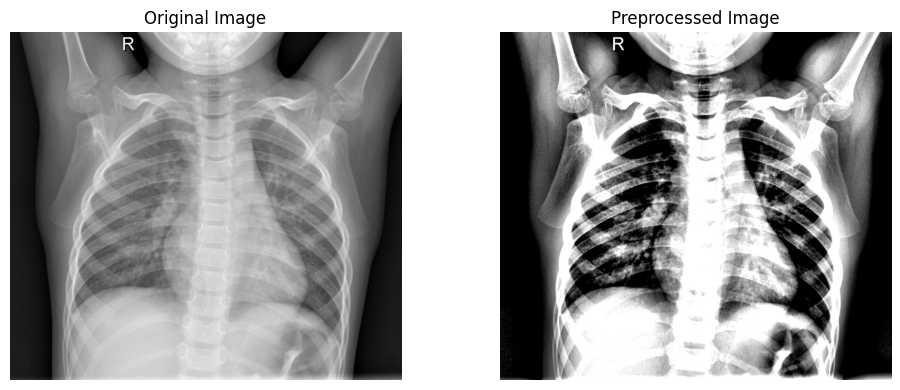

In [ ]:
import matplotlib.pyplot as plt


#Load Data
images, labels = next(train_generator)
print(f"Batch shape: {images.shape}, Labels: {labels[:5]}")

img_path = '/content/drive/MyDrive/Capstone_X-ray_Project/Data/chest_xray_lung_v1_cleaned/train/NORMAL/IM-0115-0001.jpeg'

# Load original image (BGR → RGB)
original = cv2.imread(img_path)
original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

preprocessed = custom_preprocess(original.copy())
# Convert from [-1,1] → [0,255]
preprocessed_vis = (preprocessed + 1) / 2
preprocessed_vis = np.clip(preprocessed_vis * 255, 0, 255).astype(np.uint8)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(original)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(preprocessed_vis)
plt.title("Preprocessed Image")
plt.axis("off")

plt.tight_layout()
plt.show()

**MODEL TRAINING**

In [ ]:
import os

# 1. Check your imports
print("Checking imports...")
try:
    from PIL import Image
    print("✓ PIL.Image imported successfully")
except ImportError as e:
    print(f"✗ PIL import failed: {e}")

# 2. Check a specific problematic file
problematic_path = "/content/drive/MyDrive/Capstone_X-ray_Project/Data/chest_xray_lung_v1_cleaned/train/NORMAL/IM-0410-0001.jpeg"

print(f"\nChecking problematic file: {problematic_path}")
print(f"File exists: {os.path.exists(problematic_path)}")
print(f"File size: {os.path.getsize(problematic_path) if os.path.exists(problematic_path) else 'N/A'} bytes")

# 3. Try to open it
if os.path.exists(problematic_path):
    try:
        from PIL import Image
        img = Image.open(problematic_path)
        print(f"Image format: {img.format}")
        print(f"Image size: {img.size}")
        print(f"Image mode: {img.mode}")
        img.verify()
        print("✓ Image verified successfully")
    except Exception as e:
        print(f"✗ Error: {type(e).__name__}: {e}")

Checking imports...
✓ PIL.Image imported successfully

Checking problematic file: /content/drive/MyDrive/Capstone_X-ray_Project/Data/chest_xray_lung_v1_cleaned/train/NORMAL/IM-0410-0001.jpeg
File exists: True
File size: 605273 bytes
Image format: JPEG
Image size: (1632, 1375)
Image mode: L
✓ Image verified successfully


In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define paths
train_dir = '/content/drive/MyDrive/Capstone_X-ray_Project/Data/chest_xray_lung_v1_cleaned/train'
val_dir = '/content/drive/MyDrive/Capstone_X-ray_Project/Data/chest_xray_lung_v1_cleaned/val'
test_dir = '/content/drive/MyDrive/Capstone_X-ray_Project/Data/chest_xray_lung_v1_cleaned/test'

def get_image_paths_and_labels(data_dir):
    """Get all image paths and corresponding labels from directory structure"""
    image_paths = []
    labels = []
    class_names = sorted(os.listdir(data_dir))
    class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}

    for class_name in class_names:
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_dir):
            continue

        class_idx = class_to_idx[class_name]
        for img_name in os.listdir(class_dir):
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(class_dir, img_name)
                image_paths.append(img_path)
                labels.append(class_idx)

    return image_paths, labels, class_names, class_to_idx

# Get paths and labels
train_images, train_labels, class_names, class_to_idx = get_image_paths_and_labels(train_dir)
val_images, val_labels, _, _ = get_image_paths_and_labels(val_dir)
test_images, test_labels, _, _ = get_image_paths_and_labels(test_dir)

print(f"Class names: {class_names}")
print(f"Class to index mapping: {class_to_idx}")
print(f"\nDataset sizes:")
print(f"Train: {len(train_images)} images")
print(f"Validation: {len(val_images)} images")
print(f"Test: {len(test_images)} images")
print(f"\nClass distribution in train:")
for i, class_name in enumerate(class_names):
    count = train_labels.count(i)
    print(f"  {class_name}: {count} images ({count/len(train_labels)*100:.1f}%)")

Class names: ['Cancer', 'NORMAL']
Class to index mapping: {'Cancer': 0, 'NORMAL': 1}

Dataset sizes:
Train: 4424 images
Validation: 782 images
Test: 618 images

Class distribution in train:
  Cancer: 3279 images (74.1%)
  NORMAL: 1145 images (25.9%)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
from sklearn.metrics import recall_score, accuracy_score
import os
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Mixed Precision for speed

from torch.cuda.amp import autocast, GradScaler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize scaler - enabled=True only if using cuda
scaler = torch.amp.GradScaler('cuda', enabled=device.type == 'cuda')

In [ ]:
import time # Add this import for time.sleep()

def save_checkpoint(epoch, model, optimizer, scheduler, stage_name):
   # Ensure save directory exists
    os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
    stage_filename = f"checkpoint_{stage_name.lower().replace(' ', '_')}_latest.pth"
    checkpoint_path = os.path.join(MODEL_SAVE_DIR, stage_filename)

    # Implement retry logic for saving
    max_retries = 3
    for attempt in range(max_retries):
        try:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'stage': stage_name
            }, checkpoint_path)
            print(f"💾 Checkpoint saved successfully to {checkpoint_path}")
            break # Exit loop if save is successful
        except RuntimeError as e:
            print(f"⚠️ Attempt {attempt + 1}/{max_retries}: Failed to save checkpoint to {checkpoint_path}. Error: {e}")
            if attempt < max_retries - 1:
                print("Retrying in 5 seconds...")
                time.sleep(5) # Wait before retrying
            else:
                print(f"❌ Failed to save checkpoint after {max_retries} attempts. Continuing without saving this checkpoint.")

In [ ]:
# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

def print_current_lr(optimizer, stage_name):
    print(f"\n🔍 [LR Check] Stage: {stage_name}")
    for i, param_group in enumerate(optimizer.param_groups):
        print(f"    Group {i} ({'Classifier' if i==0 else 'Backbone'}): {param_group['lr']:.8f}")

# ========== PHASE 1: Model Architecture & Setup ==========

class CancerClassifier(nn.Module):
    def __init__(self, num_classes=2, dropout_rate=0.5):
        super(CancerClassifier, self).__init__()

        # 1. Choose Base Architecture (DenseNet-121)
        self.base_model = models.densenet121(weights='IMAGENET1K_V1')

        # 2. Load Pretrained Weights (already loaded via weights='IMAGENET1K_V1')

        # 3. Modify Final Classification Layer
        # Get number of features in the last layer
        num_features = self.base_model.classifier.in_features

        # Replace classifier with new sequential block
        self.base_model.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),  # Add dropout for regularization
            nn.Linear(num_features, num_classes)
        )

        # Store which layers are frozen
        self.frozen_layers = []

    def forward(self, x):
        return self.base_model(x)

    def freeze_backbone(self):
        """Freeze all layers except classifier"""
        self.frozen_layers = []
        for name, param in self.base_model.named_parameters():
            if 'classifier' not in name:
                param.requires_grad = False
                self.frozen_layers.append(name)
            else:
                param.requires_grad = True

    def unfreeze_top_layers(self, num_layers=30):
        """Unfreeze last N layers for fine-tuning"""
        # Get all parameter names
        all_params = list(self.base_model.named_parameters())

        # Unfreeze last num_layers parameters
        for name, param in all_params[-num_layers:]:
            param.requires_grad = True
            if name in self.frozen_layers:
                self.frozen_layers.remove(name)

    def unfreeze_all(self):
        """Unfreeze all layers"""
        for param in self.base_model.parameters():
            param.requires_grad = True
        self.frozen_layers = []

# Initialize model
model = CancerClassifier(num_classes=2, dropout_rate=0.5).to(device)
model.freeze_backbone()


# --- 2. Define INITIAL Optimizer/Scheduler (Stage 1 Settings) ---
# This ensures the variables exist before the loading code runs
optimizer = optim.Adam([
    {'params': model.base_model.classifier.parameters(), 'lr': 1e-3},
    {'params': (p for n, p in model.base_model.named_parameters()
                if 'classifier' not in n and p.requires_grad), 'lr': 1e-5}
], weight_decay=1e-4)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

In [ ]:
import os

# 1. Define the base project directory
PROJECT_DIR = '/content/drive/MyDrive/Capstone_X-ray_Project'
# 2. Define the specific models directory
MODEL_SAVE_DIR = os.path.join(PROJECT_DIR, 'Models')

# 3. Create the directories if they don't exist
if not os.path.exists(MODEL_SAVE_DIR):
    os.makedirs(MODEL_SAVE_DIR)
    print(f"Created directory: {MODEL_SAVE_DIR}")
else:
    print(f"Directory already exists: {MODEL_SAVE_DIR}")

# 4. Define specific file paths using the verified directory
#CHECKPOINT_PATH = os.path.join(MODEL_SAVE_DIR, 'checkpoint_latest.pth')
CHECKPOINT_PATH = '/content/drive/MyDrive/Capstone_X-ray_Project/Models/checkpoint_fine-tuning_latest.pth'

print(f"Models will be saved to: {MODEL_SAVE_DIR}")

# Initialize variables
start_epoch = 0
resume_stage = "None"

# Load logic
# 1. Load the checkpoint
if os.path.exists(CHECKPOINT_PATH):
    print(f"🔄 Resuming from: {CHECKPOINT_PATH}")
    checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)

    # 2. Extract stage and epoch
    resume_stage = checkpoint.get('stage', 'Head Training')
    start_epoch = checkpoint.get('epoch', 0) + 1

    # 3. Load model weights
    model.load_state_dict(checkpoint['model_state_dict'])

    # 4. CRITICAL: If we are in Fine-Tuning, setup the optimizer FIRST
    if resume_stage == "Fine-Tuning":
        model.unfreeze_top_layers(num_layers=30)
        optimizer = optim.Adam([
            {'params': model.base_model.classifier.parameters(), 'lr': 1e-4},
            {'params': (p for n, p in model.base_model.named_parameters()
                        if p.requires_grad and 'classifier' not in n), 'lr': 1e-5}
        ], weight_decay=1e-4)
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

    # 5. Load optimizer/scheduler states
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if 'scheduler_state_dict' in checkpoint:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

    print(f"✅ Successfully resumed {resume_stage} at Epoch {start_epoch}")
else:
    print("🆕 No checkpoint found at the specified path. Check your folder names!")

# ... (at the very bottom of your provided code)
if os.path.exists(CHECKPOINT_PATH):
    # ... (loading logic)
    print_current_lr(optimizer, resume_stage) # <--- Add this line
else:
    print_current_lr(optimizer, "Fresh Start") # <--- Add this line

In [ ]:
def print_current_lr(optimizer, stage_name):
    print(f"\n🔍 [Learning Rate Check] Stage: {stage_name}")
    for i, param_group in enumerate(optimizer.param_groups):
        lr = param_group['lr']
        print(f"    Group {i} Learning Rate: {lr:.8f}")


# ========== Data Loading (Assuming you have train/val/test splits) ==========

class CancerDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transforms
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Assuming you have these lists from your preprocessing
# train_images, train_labels, val_images, val_labels, test_images, test_labels

# Create datasets
train_dataset = CancerDataset(train_images, train_labels, train_transform)
val_dataset = CancerDataset(val_images, val_labels, val_test_transform)
test_dataset = CancerDataset(test_images, test_labels, val_test_transform)

# ========== PHASE 2: Training Configuration ==========

# 5. Define Loss Function (Weighted CrossEntropy)
# Calculate class weights if you have class imbalance
def calculate_class_weights(labels):
    class_counts = np.bincount(labels)
    total = len(labels)
    weights = [total / (len(class_counts) * count) for count in class_counts]
    return torch.FloatTensor(weights).to(device)

class_weights = calculate_class_weights(train_labels)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# 6. Choose Optimizer
# Freeze backbone initially
model.freeze_backbone()

# Different learning rates for different parts
optimizer = optim.Adam([
    {'params': model.base_model.classifier.parameters(), 'lr': 1e-3},
    {'params': (p for n, p in model.base_model.named_parameters()
                if 'classifier' not in n and p.requires_grad), 'lr': 1e-5}
], weight_decay=1e-4)  # Weight decay for regularization

# 7. Learning Rate Strategy (implemented above in optimizer)
# 8. Batch Size Selection (for lower memory usage)
batch_size = 16  # Reduced for lower memory
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# 9. Epoch Planning
head_epochs = 10
fine_tune_epochs = 20

# Learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# ========== Training Functions ==========

def train_epoch(model, dataloader, criterion, optimizer, device):
    """PHASE 3: Training Process for one epoch"""
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    for batch_idx, (images, labels) in enumerate(dataloader):
        # Move to device
        images, labels = images.to(device), labels.to(device)

        # 11. Forward Pass
        optimizer.zero_grad()

        with torch.amp.autocast('cuda', enabled=device.type == 'cuda'):
          outputs = model(images)
          # 12. Loss Computation
          loss = criterion(outputs, labels)


        # 13. Backpropagation
        #loss.backward()
        scaler.scale(loss).backward()

        # 14. Weight Update
        #optimizer.step()
        scaler.step(optimizer)
        scaler.update()

        # 15. Track Training Metrics
        running_loss += loss.item()

        # Get predictions
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Optional: print progress
        if batch_idx % 10 == 0:
            print(f'  Batch {batch_idx}/{len(dataloader)}, Loss: {loss.item():.4f}')

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = accuracy_score(all_labels, all_preds)

    # Calculate sensitivity (recall for cancer class)
    if 1 in all_labels:  # If there are cancer cases in this epoch
        epoch_sensitivity = recall_score(all_labels, all_preds, pos_label=1)
    else:
        epoch_sensitivity = 0.0

    return epoch_loss, epoch_acc, epoch_sensitivity

def validate_epoch(model, dataloader, criterion, device):
    """PHASE 4: Validation during training"""
    # 16. Switch to evaluation mode
    model.eval()

    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        # 17. Run on validation dataset
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            # 11. Forward Pass
            outputs = model(images)

            # 12. Loss Computation
            loss = criterion(outputs, labels)

            running_loss += loss.item()

            # Get predictions
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # 18. Compute validation metrics
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = accuracy_score(all_labels, all_preds)

    # Calculate sensitivity
    if 1 in all_labels:
        epoch_sensitivity = recall_score(all_labels, all_preds, pos_label=1)
    else:
        epoch_sensitivity = 0.0

    return epoch_loss, epoch_acc, epoch_sensitivity

# ========== Training Loop with Early Stopping ==========

def train_model(model, train_loader, val_loader, criterion, optimizer,
                scheduler, num_epochs, stage_name="Training", start_epoch=0):

    print(f"\n{'='*50}")
    print(f"Starting {stage_name}")
    print(f"{'='*50}")

    best_val_loss = float('inf')
    patience_counter = 0
    patience = 7  # Early stopping patience

    # 19. Early stopping tracking
    early_stopping = False

    for epoch in range(start_epoch, num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 30)

        # 10. Initialize training loop for each epoch
        train_loss, train_acc, train_sens = train_epoch(
            model, train_loader, criterion, optimizer, device
        )

        # PHASE 4: Validation
        val_loss, val_acc, val_sens = validate_epoch(
            model, val_loader, criterion, device
        )

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Sens: {train_sens:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Sens: {val_sens:.4f}")

        # Update learning rate based on validation loss
        scheduler.step(val_loss)

        save_checkpoint(epoch, model, optimizer, scheduler, stage_name)
        print(f"💾 Checkpoint saved at epoch {epoch}")


        # 20. Save best model checkpoint
        if val_loss < best_val_loss:
          best_val_loss = val_loss

          # Local Colab save (keeps original behavior)
          local_model_path = f"best_model_{stage_name.lower().replace(' ', '_')}.pth"

          torch.save({
              'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'val_loss': val_loss,
              'val_acc': val_acc,
              'stage': stage_name,
          }, local_model_path)

          # Google Drive save (NEW)
          drive_model_path = os.path.join(
              MODEL_SAVE_DIR,
              f"best_model_{stage_name.lower().replace(' ', '_')}.pth"
          )

          try:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
                'val_acc': val_acc,
                'stage': stage_name,
            }, drive_model_path)

            print(f"Saved best model with val_loss: {val_loss:.4f}")
            print(f"Saved best {stage_name} model locally and to Google Drive")

          except Exception as e:
            print("⚠️ Google Drive save failed:", e)
            print("Model still saved locally.")

          patience_counter = 0
        else:
          patience_counter += 1

        # Check for early stopping
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            early_stopping = True
            break

    return early_stopping




# ========== STAGE 1: Train Classifier Head ==========

if resume_stage in ["None", "Head Training"]:
    print("\n" + "="*60)
    print(f"STAGE 1: Training Classifier Head (Resuming: {resume_stage})")
    print("="*60)

    model.freeze_backbone()

    print_current_lr(optimizer, "Head Training")

    # Only run if we haven't finished Stage 1
    early_stopped = train_model(
        model, train_loader, val_loader, criterion, optimizer, scheduler,
        num_epochs=head_epochs, stage_name="Head Training",
        start_epoch=start_epoch if resume_stage == "Head Training" else 0
    )

    # After Stage 1 completes, reset variables for Stage 2
    start_epoch = 0
    resume_stage = "Fine-Tuning"
else:
    print("⏩ Skipping Stage 1: Already reached Fine-Tuning.")

# ========== PHASE 5: Fine-Tuning Stage ==========

print("\n" + "="*60)
print("STAGE 2: Fine-Tuning Selected Layers")
print("="*60)

# 21. Unfreeze selected layers
print("Unfreezing last 30 layers for fine-tuning...")
model.unfreeze_top_layers(num_layers=30)

# 22. Reduce learning rate for fine-tuning
# Use smaller LR for pretrained layers
if resume_stage == "Fine-Tuning" and start_epoch > 0:
    print(f"✅ Resuming Stage 2: Optimizer already loaded from checkpoint (Epoch {start_epoch})")
    # No need to redefine 'optimizer' here because your loading logic
    # at the very top of the script already handled it.
    print_current_lr(optimizer, "Fine-Tuning")
else:
    print("🆕 Starting Stage 2 fresh: Initializing Fine-Tuning Optimizer...")
    optimizer = optim.Adam([
        {'params': model.base_model.classifier.parameters(), 'lr': 1e-4},
        {'params': (p for n, p in model.base_model.named_parameters()
                    if p.requires_grad and 'classifier' not in n), 'lr': 1e-5}
    ], weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# 23. Continue training
early_stopped = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler,
    num_epochs=fine_tune_epochs, stage_name="Fine-Tuning",
    start_epoch=start_epoch if resume_stage == "Fine-Tuning" else 0
)

# Prepare the dictionary to match your loading logic
final_model_data = {
    'model_state_dict': model.state_dict(),
    'stage': 'Final'
}

# 24. Save final best model locally
torch.save(final_model_data, 'final_cancer_classifier.pth')
print("\nSaved final model as 'final_cancer_classifier.pth'")

# Save final model to Google Drive
final_drive_path = os.path.join(MODEL_SAVE_DIR, "final_cancer_classifier.pth")
torch.save(final_model_data, final_drive_path)
print(f"Final model saved to Google Drive at {final_drive_path}")

# ========== PHASE 6: Final Testing (Corrected Version) ==========

def evaluate_test_set(model, test_loader, device):
    """Evaluate on unseen test data"""
    print("\n" + "="*60)
    print("PHASE 6: Final Testing on Unseen Data")
    print("="*60)

    # 25. Load best saved model - Corrected Path and Key handling
    # The path must match how it was saved in Stage 2 (Fine-Tuning)
    best_fine_tuned_path = os.path.join(MODEL_SAVE_DIR, "best_model_fine-tuning.pth")

    if not os.path.exists(best_fine_tuned_path):
        print(f"❌ Error: Could not find {best_fine_tuned_path}")
        return None

    print(f"Loading best weights from: {best_fine_tuned_path}")
    checkpoint = torch.load(best_fine_tuned_path, map_location=device)

    # Check if we are loading a full checkpoint or just a state_dict
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"✓ Loaded checkpoint from epoch {checkpoint.get('epoch', 'unknown')}")
    else:
        model.load_state_dict(checkpoint)
        print("✓ Loaded state_dict directly")

    # 26. Evaluate on test dataset
    model.eval()

    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            probabilities = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probabilities.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)

    if 1 in all_labels:
        sensitivity = recall_score(all_labels, all_preds, pos_label=1)
        specificity = recall_score(all_labels, all_preds, pos_label=0)
    else:
        sensitivity = 0.0
        specificity = 0.0

    # Print results
    print(f"\nTest Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Sensitivity (Cancer Recall): {sensitivity:.4f}")
    print(f"Specificity (Normal Recall): {specificity:.4f}")

    # Confusion matrix
    from sklearn.metrics import confusion_matrix, classification_report
    cm = confusion_matrix(all_labels, all_preds)
    print(f"\nConfusion Matrix:")
    print(cm)
    print(f"\nClassification Report:")
    print(classification_report(all_labels, all_preds,
                               target_names=['Normal', 'Cancer']))

    return accuracy, sensitivity, specificity, all_probs

# Run evaluation
test_accuracy, test_sensitivity, test_specificity, probabilities = evaluate_test_set(
    model, test_loader, device
)

In [ ]:

def predict_single_image(model, image_path, transform, device):
    """Predict for a single image"""
    model.eval()

    # Load and transform image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_tensor)
        probability = torch.softmax(output, dim=1)
        _, prediction = torch.max(output, 1)

    confidence = probability[0][prediction.item()].item()
    class_name = 'Cancer' if prediction.item() == 1 else 'Normal'

    return {
        'class': class_name,
        'confidence': confidence,
        'probabilities': probability.cpu().numpy()[0]
    }

# Example usage:
result = predict_single_image(model, 'path/to/image.jpg', val_test_transform, device)
print(f"Prediction: {result['class']}, Confidence: {result['confidence']:.2%}")